<img src='harrypotter_image.png' width='200px' style="float:left;margin-right:10pt"></img>
# Illustration of Static Hypergraphs using Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. 

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in this tutorial's directory.

In [1]:
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import scipy
from scipy.sparse import coo_matrix, csr_matrix, issparse
import pandas as pd
import numpy as np
import itertools as it
import sys
from harrypotter import HarryPotter

## The Harry Potter Dataset: 
To use a csv file for a Static Hypergraph, we need every cell filled with a label. 
We have edited the Harry Potter dataset so that it has 5 categories and every cell is filled. Where a value is unknown, we marked it as "Unknown *category_name*". 

In [2]:
hogwarts = HarryPotter()

In [3]:
hogwarts.dataframe

,House,Blood status,Species,Hair colour,Eye colour
0,Gryffindor,Half-blood,Human,Black,Bright green
1,Gryffindor,Pure-blood,Human,Red,Blue
2,Gryffindor,Muggle-born,Human,Brown,Brown
3,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
4,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
135,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
136,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
137,Unknown House,Pure-blood or half-blood,Human,Blond,Blue
138,Unknown House,Unknown Blood status,Elf,Unknown Hair colour,Unknown Eye colour


### We define a labeling based on the categories and store it in an Ordered Dictionary.
The ordering of labels is determined by their order of appearance in the table with the exception of Unknown labels, which are always listed first.

In [4]:
hogwarts.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25')),
             ('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
 

### We next create a tensor with dimension equal to the number of categories and indexed by the labels. 
We remove duplicate rows and create a boolean 0-1 tensor.
A 1 in entry $(x_0,x_1,x_2,x_3,x_4, x_5)$ indicates that there is a record in the data corresponding to:
$
\text{'House':hogwarts.labels['House']}[x_0],\text{'Blood Status':hogwarts.labels['Blood Status']}[x_1]\text{...etc...}
$

The tensor may be stored as a list of its nonzero indices, or in a sparse format taking the transpose of that list, or as a `numpy.ndarray`.

In [5]:
## List of nonzero indices
hogwarts.data

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  3],
       [ 0,  0,  1,  1,  4],
       [ 0,  0,  1,  2,  3],
       [ 0,  0,  1, 19,  0],
       [ 0,  0,  1, 19, 25],
       [ 0,  0,  1, 26, 18],
       [ 0,  0,  3, 19,  0],
       [ 0,  0,  6, 20,  4],
       [ 0,  0,  7, 16, 15],
       [ 0,  0,  9,  0,  0],
       [ 0,  1,  1, 19, 22],
       [ 0,  1,  1, 29,  3],
       [ 0,  2,  1,  2,  7],
       [ 0,  2,  1, 15,  0],
       [ 0,  2,  1, 18,  4],
       [ 0,  2,  1, 19,  0],
       [ 0,  2,  1, 19, 17],
       [ 0,  2,  1, 27, 20],
       [ 0,  2,  1, 31, 23],
       [ 0,  5,  1,  0,  0],
       [ 0,  5,  1,  1,  0],
       [ 0,  5,  1,  3, 19],
       [ 0,  5,  1,  5,  2],
       [ 0,  5,  1, 10,  9],
       [ 0,  5,  1, 15,  0],
       [ 0,  5,  1, 19,  0],
       [ 0,  5,  1, 21, 14],
       [ 0,  5,  1, 25,  0],
       [ 0,  5,  1, 30,  3],
       [ 0,  9,  1,  1,  0],
       [ 0,  9,  1,  5,  2],
       [ 0,  9

In [6]:
hogwarts.data.shape

(126, 5)

In [7]:
## This array is indexed by the label in the label dictionary. 
## It is generally very sparse and can be too large to hold in memory.
hogwarts.arr

array([[[[[1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[1, 0, 0, ..., 0, 0, 0],
          [1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
       

In [8]:
hogwarts.arr.shape

(7, 11, 10, 36, 26)

In [9]:
## The sparse format is preferred so a supplied array will be rewritten in this form
## If an array is supplied the labels should correspond to the indices already, 
## so no renumbering should be done
data_from_array = dfa = np.array(hogwarts.arr.nonzero()).transpose()
data_from_array.shape

(126, 5)

In [10]:
## We recover the original shape by noting the indices used in each dimension
[max(x)+1 for x in dfa.transpose()]

[7, 11, 10, 36, 26]

In [11]:
## Confirm that we have the same data when we retrieve it from the array
np.allclose(np.sort(dfa,axis=0), np.sort(hogwarts.data, axis=0))

True

## StaticEntity and StaticEntitySet

The entire dataset has now been represented using a data array or tensor array and a dictionary associating positions in the tensor array and values in the data array with values in the original data.

The basic object in HyperNetX, which holds the data and label dictionary for a static hypergraph, is a `StaticEntity`.

Each dimension of the array, is considered a "level" in the StaticEntity. A level's order corresponds to its position in the datatable. In terms of the original Entity structure in HyperNetX, levels 'loosely' reference an order of containment. Elements of the the 2nd level belong to elements in the 1st column. Pairwise one can say the elements of one level belong to the elements of its predecessor column. The order of levels is given by the order of keys in the labels:

In [12]:
E = hnx.StaticEntity(arr = hogwarts.arr, labels = hogwarts.labels)
E.keys

array(['House', 'Blood status', 'Species', 'Hair colour', 'Eye colour'],
      dtype='<U12')

### Using the same nomenclature as `hypernetx.Entity`, the elements of a StaticEntity refer to the first level and its children refer to the second level.

In [13]:
E = hnx.StaticEntity(arr=hogwarts.arr, labels=hogwarts.labels)
E.uidset,E.elements,E.children

(frozenset({'Beauxbatons Academy of Magic',
            'Durmstrang Institute',
            'Gryffindor',
            'Hufflepuff',
            'Ravenclaw',
            'Slytherin',
            'Unknown House'}),
 OrderedDict([('Unknown House',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Pure-blood or half-blood',
                'Muggle',
                'Squib']),
              ('Gryffindor',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human',
                'Pure-blood or half-blood']),
              ('Ravenclaw',
               ['Unknown Blood status',
                'Half-blood',
                'Muggle-born',
                'Pure-blood or half-blood',
                'Part-Goblin',
                'Muggle-born or half-blood']),
              ('Slytherin',
               ['Half-blood', 'Pure-blood',

### Levels can be reordered and any pair of columns may be organized to be elements and children.

In [14]:
E.elements_by_level(level1=2,level2=3,translate=True)

OrderedDict([('Unknown Species', ['Unknown Hair colour']),
             ('Human',
              ['Unknown Hair colour',
               'Black',
               'Red',
               'Brown',
               'Silver| formerly auburn',
               'Blond',
               'Sandy',
               'Auburn',
               'Colourless and balding',
               'Dark',
               'Mousy',
               'Dirty-blonde',
               'Reddish-blonde',
               'Blonde',
               'White-blond',
               'Iron grey',
               'Bald',
               'Grey',
               'Straw blond',
               'Variable',
               'Red brown',
               'Brown/greying',
               'Silver| formerly black',
               'Tawny',
               'Silver',
               'Silvery-blonde',
               'Ginger',
               'Straw-coloured',
               'Red ',
               'Reddish-brown',
               'Mousy brown',
               'Jet-black',
   

In [15]:
F = E.restrict_to_levels([2,3,1]) ## This generates a new StaticEntity
F.labels


OrderedDict([('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
                     'Light brown flecked with grey', 'Colourless and balding', 'Dark',
                     'Mousy', 'Dirty-blonde', 'White', 'Reddish-blonde', 'Blonde',
                     'White-blond', 'Iron grey', 'Bald', 'Grey', 'White (balding)',
                     'Straw blond', 'Variable', 'Red brown', 'Brown/greying',
                     'Silver| formerly black', 'Tawny', 'Silver', 'Silvery-blonde',
                     'Ginger', 'Straw-coloured', 'Red ', 'Reddish-brown', 'Mousy brown',
                     'Jet-black', 'White blo

In [16]:
F.uidset ## names of the elements

frozenset({'Centaur',
           'Elf',
           'Ghost',
           'Half-Human/Half-Giant',
           'Human',
           'Human (Metamorphmagus)',
           'Human (Werewolf traits)',
           'Human(goblin ancestry)',
           'Unknown Species',
           'Werewolf'})

In [17]:
F.children  ## the names of all values associated with the elements

{'Auburn',
 'Bald',
 'Black',
 'Blond',
 'Blonde',
 'Brown',
 'Brown/greying',
 'Colourless and balding',
 'Dark',
 'Dirty-blonde',
 'Ginger',
 'Grey',
 'Iron grey',
 'Jet-black',
 'Light brown flecked with grey',
 'Mousy',
 'Mousy brown',
 'Red',
 'Red ',
 'Red brown',
 'Reddish-blonde',
 'Reddish-brown',
 'Sandy',
 'Silver',
 'Silvery-blonde',
 'Silver| formerly auburn',
 'Silver| formerly black',
 'Straw blond',
 'Straw-coloured',
 'Tawny',
 'Unknown Hair colour',
 'Variable',
 'White',
 'White (balding)',
 'White blond',
 'White-blond'}

### A StaticEntitySet is a StaticEntity restricted to two levels. 
By default, a StaticEntity will grab the 1st two dimensions of the of the array and first two keys of the labels, but any pair of levels may be specified. 

In [18]:
ES = hnx.StaticEntitySet(data=hogwarts.data, labels=hogwarts.labels, level1=0, level2=1)
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

In [19]:
ES = hnx.StaticEntitySet(E)
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

## Static Hypergraph
A static hypergraph is one where all nodes and edges are known at the time of construction. This permits an internal ordering and uid structure for easy reference and faster computation of metrics.

The nodes and edges of a static Hypergraph are stored using the StaticEntitySet structure. 

A static Hypergraph may be instantiated by adding the keyword argument `static=True`. Hypergraphs have `static=False` by default. A static Hypergraph may be created with a set system of the form:
1. *dict* with static=True 
2. *iterable of iterables* with static=True, 
3. `hypernetx.EntitySet` with static=True
4. `hypernetx.StaticEntity` (static is automatically set to True),
5. `hypernetx.StaticEntitySet` (static is automatically set to True).


In [20]:
## example, instantiate from a dictionary
d = E.elements
print(d)
Hdict = hnx.Hypergraph(d,static=True)

## in this case the keys will be integers
Hdict.edges.labels

OrderedDict([('Unknown House', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Pure-blood or half-blood', 'Muggle', 'Squib']), ('Gryffindor', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born', 'Part-Human', 'Pure-blood or half-blood']), ('Ravenclaw', ['Unknown Blood status', 'Half-blood', 'Muggle-born', 'Pure-blood or half-blood', 'Part-Goblin', 'Muggle-born or half-blood']), ('Slytherin', ['Half-blood', 'Pure-blood', 'Pure-blood or half-blood']), ('Hufflepuff', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born', 'Pure-blood or half-blood']), ('Beauxbatons Academy of Magic', ['Part-Human', 'Quarter-Veela']), ('Durmstrang Institute', ['Pure-blood or half-blood'])])


OrderedDict([('0',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('1',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood',
                     'Pure-blood or half-blood', 'Muggle', 'Squib', 'Muggle-born',
                     'Part-Human', 'Part-Goblin', 'Muggle-born or half-blood',
                     'Quarter-Veela'], dtype='<U25'))])

In [21]:
## Create a StaticEntitySet from an StaticEntity (restricts to two columns)
ESE = hnx.StaticEntitySet(entity=E)
ESE.incidence_matrix().todense()
ESE.keys

array(['House', 'Blood status'], dtype='<U12')

In [22]:
## Create a hypergraph from a StaticEntity
HE = hnx.Hypergraph(E)
HE.dataframe()

,Unknown House,Gryffindor,Ravenclaw,Slytherin,Hufflepuff,Beauxbatons Academy of Magic,Durmstrang Institute
Unknown Blood status,1,1,1,0,1,0,0
Half-blood,1,1,1,1,1,0,0
Pure-blood,1,1,0,1,1,0,0
Muggle-born,0,1,1,0,1,0,0
Part-Human,0,1,0,0,0,1,0
Pure-blood or half-blood,1,1,1,1,1,0,1
Part-Goblin,0,0,1,0,0,0,0
Muggle-born or half-blood,0,0,1,0,0,0,0
Quarter-Veela,0,0,0,0,0,1,0
Muggle,1,0,0,0,0,0,0


In [23]:
HF = hnx.Hypergraph(F)  ## F restricted to columns [2,3,1] so the hypergraph will be on columns 2 and 3
HF.dataframe()

,Unknown Species,Human,Half-Human/Half-Giant,Werewolf,Human (Werewolf traits),Human(goblin ancestry),Ghost,Centaur,Human (Metamorphmagus),Elf
Unknown Hair colour,1,1,0,0,0,0,1,0,0,1
Black,0,1,1,0,0,0,1,0,0,0
Red,0,1,0,0,1,0,0,0,0,0
Brown,0,1,1,0,0,0,1,0,0,0
Silver| formerly auburn,0,1,0,0,0,0,0,0,0,0
Blond,0,1,0,0,0,0,0,0,0,0
Sandy,0,1,0,0,0,0,0,0,0,0
Auburn,0,1,0,0,0,0,0,0,0,0
Light brown flecked with grey,0,0,0,1,0,0,0,0,0,0
Colourless and balding,0,1,0,0,0,0,0,0,0,0


In [24]:
## example, instantiate from an EntitySet
H = hnx.Hypergraph(ESE)
H.edges

StaticEntitySet(None,['Beauxbatons Academy of Magic', 'Slytherin', 'Ravenclaw', 'Hufflepuff', 'Gryffindor', 'Unknown House', 'Durmstrang Institute'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])})

In [25]:
H.incidence_matrix()

<11x7 sparse matrix of type '<class 'numpy.int64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [26]:
H.dataframe()

,Unknown House,Gryffindor,Ravenclaw,Slytherin,Hufflepuff,Beauxbatons Academy of Magic,Durmstrang Institute
Unknown Blood status,1,1,1,0,1,0,0
Half-blood,1,1,1,1,1,0,0
Pure-blood,1,1,0,1,1,0,0
Muggle-born,0,1,1,0,1,0,0
Part-Human,0,1,0,0,0,1,0
Pure-blood or half-blood,1,1,1,1,1,0,1
Part-Goblin,0,0,1,0,0,0,0
Muggle-born or half-blood,0,0,1,0,0,0,0
Quarter-Veela,0,0,0,0,0,1,0
Muggle,1,0,0,0,0,0,0


### Restrict to specific edges and nodes as before

In [27]:
## Restrict to edges
HH = H.restrict_to_edges(['Gryffindor','Ravenclaw','Slytherin','Hufflepuff'])
HH.dataframe()

,Gryffindor,Ravenclaw,Slytherin,Hufflepuff
Unknown Blood status,1,1,0,1
Half-blood,1,1,1,1
Pure-blood,1,0,1,1
Muggle-born,1,1,0,1
Part-Human,1,0,0,0
Pure-blood or half-blood,1,1,1,1
Part-Goblin,0,1,0,0
Muggle-born or half-blood,0,1,0,0


In [28]:
## Restrict to nodes
nodelist = [nd for nd in HH.nodes if 'pure' in str(nd).lower()]
HHD = HH.restrict_to_nodes(nodelist)
HHD.dataframe()

,Gryffindor,Slytherin,Hufflepuff,Ravenclaw
Pure-blood,1,1,1,0
Pure-blood or half-blood,1,1,1,1


In [29]:
## Or restrict first then create the hypergraph
J = ES.restrict_to_indices([1,2,3,4])
HJ = hnx.Hypergraph(J)
HJ.dataframe()

,Gryffindor,Ravenclaw,Slytherin,Hufflepuff
Unknown Blood status,1,1,0,1
Half-blood,1,1,1,1
Pure-blood,1,0,1,1
Muggle-born,1,1,0,1
Part-Human,1,0,0,0
Pure-blood or half-blood,1,1,1,1
Part-Goblin,0,1,0,0
Muggle-born or half-blood,0,1,0,0


In [30]:
HJDual = HJ.dual()
HJDual.dataframe()

,Unknown Blood status,Half-blood,Pure-blood,Muggle-born,Part-Human,Pure-blood or half-blood,Part-Goblin,Muggle-born or half-blood
Gryffindor,1,1,1,1,1,1,0,0
Ravenclaw,1,1,0,1,0,1,1,1
Slytherin,0,1,1,0,0,1,0,0
Hufflepuff,1,1,1,1,0,1,0,0


**A Hypergraph with static=True may be converted to a static=False hypergraph if dynamic properties or visualizations are needed.**  
(Similarly any hypergraph may be converted to a static hypergraph using its incidence_dict.)

EntitySet(:Edges,['Ravenclaw', 'Gryffindor', 'Slytherin', 'Hufflepuff'],{})

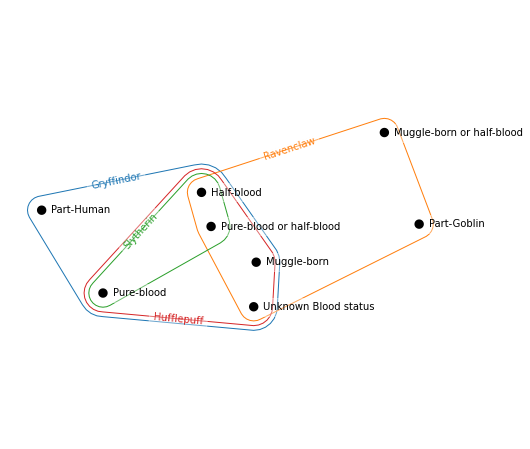

In [31]:
HJDyn = HJ.remove_static()
hnx.draw(HJDyn);
HJDyn.edges

## Collapse identical elements
This method exists to collapse identical nodes and edges and is implemented for dynamic hypergraaphs.
We wish to do the same for large unwieldy hypergraphs stored as static.

{'Unknown Blood status:2': ['Unknown Blood status', 'Muggle-born'],
 'Half-blood:2': ['Half-blood', 'Pure-blood or half-blood'],
 'Pure-blood:1': ['Pure-blood'],
 'Part-Human:1': ['Part-Human'],
 'Part-Goblin:2': ['Part-Goblin', 'Muggle-born or half-blood']}

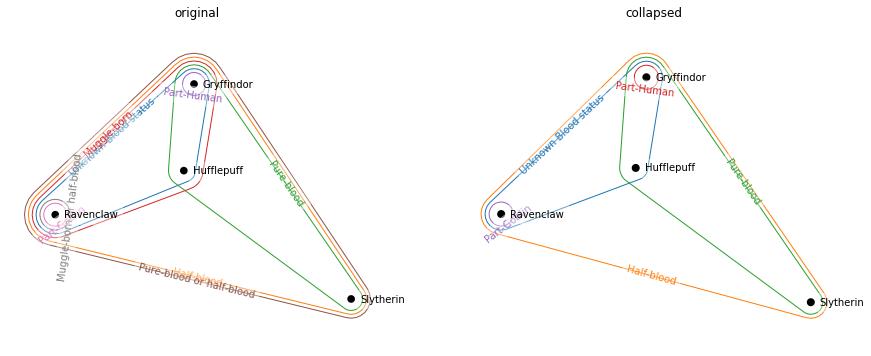

In [32]:
Hjd,clses = HJDual.collapse_edges(use_reps=True, return_counts=True, return_equivalence_classes=True)

## now draw the dynamic versions
fig,ax = plt.subplots(1,2,figsize=(15,6))
pos = hnx.draw(HJDual.remove_static(),ax=ax[0],return_pos=True);
ax[0].set_title('original')
hnx.draw(Hjd.remove_static(),ax=ax[1],pos=pos);
ax[1].set_title('collapsed');
clses

### Hypergraph methods apply to both static and dynamic hypergraphs

In [33]:
H.isstatic

True

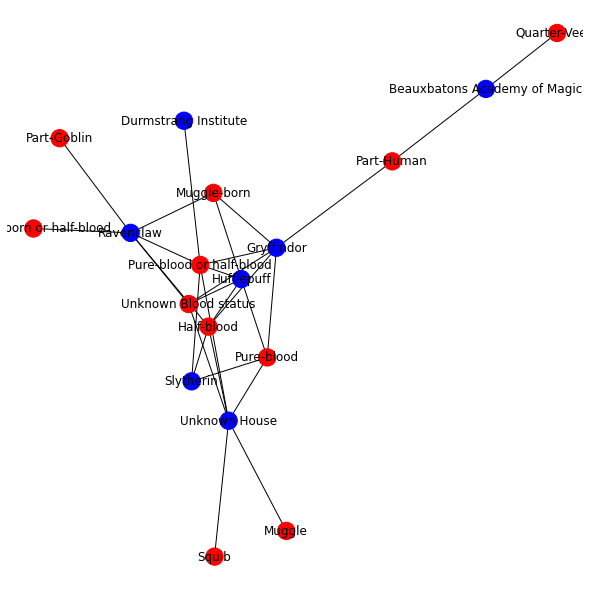

In [34]:
G = H.bipartite()
cmap = ['r' if G.nodes[n]['bipartite']==0 else 'b' for n in G.nodes ]
nx.draw(H.bipartite(),node_color=cmap,with_labels=True)

In [35]:
hnx.dist_stats(H)

{'nrows': 11,
 'ncols': 7,
 'aspect ratio': 1.5714285714285714,
 'ncells': 29,
 'density': 0.37662337662337664,
 'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
 'node degree centrality stats': {'min': 1,
  'max': 6,
  'mean': 2.6363636363636362,
  'median': 2.0,
  'std': 1.7721444263289026},
 'node degree hist': Counter({6: 1, 5: 1, 4: 2, 3: 1, 2: 1, 1: 5}),
 'max node degree': 6,
 'edge size list': [6, 6, 6, 5, 3, 2, 1],
 'edge size centrality stats': {'min': 1,
  'max': 6,
  'mean': 4.142857142857143,
  'median': 5.0,
  'std': 1.9587584572574412},
 'edge size hist': Counter({6: 3, 5: 1, 3: 1, 2: 1, 1: 1}),
 'max edge size': 6,
 'comp nodes list': [11],
 'comp nodes hist': Counter({11: 1}),
 'comp nodes centrality stats': {'min': 11,
  'max': 11,
  'mean': 11.0,
  'median': 11.0,
  'std': 0.0},
 'comp edges list': [7],
 'comp edges hist': Counter({7: 1}),
 'comp edges centrality stats': {'min': 7,
  'max': 7,
  'mean': 7.0,
  'median': 7.0,
  'std': 0.0},
 'num comps': 1}

In [36]:
list(np.array(np.sum(H.incidence_matrix(), axis=0))[0])

[6, 6, 6, 3, 5, 2, 1]

In [37]:
sorted(H.edge_size_dist(), reverse=True)[0]

6

In [38]:
H.edge_size_dist()

[6, 6, 6, 3, 5, 2, 1]

In [39]:
list(np.array(np.sum(H.incidence_matrix(), axis=0))[0])

[6, 6, 6, 3, 5, 2, 1]

In [40]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  5,  9, 10,  0,  1,  2,  3,  4,  5,  0,  1,  3,  5,  6,
          7,  1,  2,  5,  0,  1,  2,  3,  5,  4,  8,  5]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {},
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 'edge_size_dist': [6, 6, 6, 3, 5, 2, 1],
 'dist_stats': {'nrows': 11,
  'ncols': 7,
  'aspect ratio': 1.5714285714285714,
  'ncells': 29,
  'density': 0.37662337662337664,
  'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
  'node degree centrality stats': {'min': 1,
   'max': 6,
   'mean': 2.6363636363636362,
   'median': 2.0,
   'std': 1.7721444263289026},
  'node degree hist': Counter({6: 1, 5: 1, 4: 2, 3: 1, 2: 1, 1: 5}),
  'max node degree': 6,
  'edge size li

In [41]:
lnodes,ledges = H.shape
lnodes

11

In [42]:
print(hnx.info(H,node='Squib'))

Node 'Squib' has the following properties:
Degree: 1
Contained in: ['Unknown House']
Neighbors: ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Pure-blood or half-blood', 'Muggle']
